# Milestone Project1: Food Vision Big

## Check GPU

Google Colab offers free GPUs, however, not all of them are compatible with mixed precision training.

Google Colab offers:
* K80 (not compatible)
* P100 (not compatible)
* Tesla T4 (compatible)

Knowing this, in order to use mixed precision training we need access to a Tesla T4  (from within Google Colab) or if we're using our own hardware, our GPU needs a score of 7.0+

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ba264a63-6d67-8b65-3095-754e8ae816dc)


## Get helper functions

In past modules, we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather than rewrite all of these, we can import a script and load them in from there.

The script we've got available can be found on GitHub

In [2]:
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-09-02 12:44:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-09-02 12:44:46 (93.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [5]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print('food101' in datasets_list) # is our target dataset in the list of TFDS dataset?

True


In [6]:
# Load in the data (takes 5-6 minutes in Google Colab)
(train_data, test_data), ds_info = tfds.load(name = 'food101',
                                             split = ['train', 'validation'],
                                             shuffle_files = True,
                                             as_supervised = True, # data gets returned in tuple format (data, label),
                                             with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteO9NJRO/food101-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/food101/2.0.0.incompleteO9NJRO/food101-validation.tfrecord*...:   0%|         …

Dataset food101 downloaded and prepared to ~/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from TensorFlow Datasets

To become one with our data, we want to find:
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g. are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [7]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [8]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [9]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [10]:
# What does one sample of our training data look like?
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [11]:
# Output info abour our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (512, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
  


In [12]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 85,  84,  92],
        [ 86,  85,  93],
        [ 93,  92, 100],
        ...,
        [120, 196, 245],
        [120, 198, 246],
        [121, 199, 247]],

       [[ 88,  88,  96],
        [ 82,  82,  90],
        [ 88,  88,  96],
        ...,
        [116, 192, 244],
        [118, 195, 249],
        [119, 196, 248]],

       [[ 77,  80,  89],
        [ 75,  78,  87],
        [ 82,  86,  95],
        ...,
        [115, 189, 252],
        [117, 192, 255],
        [118, 194, 255]],

       ...,

       [[159, 166, 194],
        [154, 161, 187],
        [171, 178, 204],
        ...,
        [219, 216, 235],
        [223, 220, 239],
        [227, 226, 244]],

       [[170, 179, 208],
        [169, 179, 206],
        [173, 183, 210],
        ...,
        [218, 217, 235],
        [223, 222, 240],
        [226, 227, 245]],

       [[168, 177, 206],
        [170, 179, 208],
        [152, 162, 189],
        ...,
        [224, 223, 24

In [13]:
# What are the min and max values of our image tensor?
import tensorflow as tf 
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

## Plot an image from TensorFlow Datasets

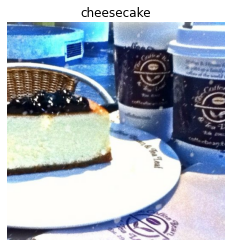

In [14]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is assosciated with the right image
plt.axis('off');

## Create preprocessing functions for our data 

Neural network perform best when data is in a certain way (e.g. batched, normalized, etc).

However, not all data (including data from the TensorFlow Datasets) comes like this.

So in order to get it ready for a neural network, we'll often have to write preprocessing functions and map it to our data. 

What we know about our data:
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:
* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow likes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensors generally perform better

With these points in mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.applications we don't need to rescale our data (these architectures have rescaling built-in).

This means our functions needs to:
1. Reshape our images to all the same size 
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [17]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape = 224):
  """
  Converts image datatype from 'uint8' to 'float32' and reshapes image to [img_shape, img_shape, colour_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape target image
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [19]:
# Preprocess a single sample image and check the outputs
preprocessed_image = preprocess_img(image, label)[0]
print(f'Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}\n')
print(f'Image after preprocessing:\n {preprocessed_image[:2]}..., \nShape: {preprocessed_image.shape}, \nDatatype: {preprocessed_image.dtype}')

Image before preprocessing:
 [[[ 85  84  92]
  [ 86  85  93]
  [ 93  92 100]
  ...
  [120 196 245]
  [120 198 246]
  [121 199 247]]

 [[ 88  88  96]
  [ 82  82  90]
  [ 88  88  96]
  ...
  [116 192 244]
  [118 195 249]
  [119 196 248]]]..., 
Shape: (512, 512, 3), 
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 84.67857   84.321434  92.321434]
  [ 87.19898   86.841835  94.841835]
  [ 84.72959   84.581635  94.72449 ]
  ...
  [119.50503  194.93877  245.85202 ]
  [114.974525 190.97452  241.90309 ]
  [119.071465 196.4286   247.82652 ]]

 [[ 75.647964  84.21939   93.21939 ]
  [ 71.45407   80.959175  89.959175]
  [ 78.03061   87.20408   97.47449 ]
  ...
  [113.31632  182.62755  249.35715 ]
  [106.57655  176.86227  245.4337  ]
  [108.601944 179.9796   248.16833 ]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're going to make our data input pipeline run really fast.

In [20]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size = 1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)

# Map preprocessing function to test data 
test_data = test_data.map(map_func = preprocess_img, num_parallel_calls = tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
# Check the train and the test data
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> 🔑**Note:** Let's explain what we've done above; We've said to the TensorFlow , map this preprocessing function (`preprocess_img`) across our training dataset, then after you've finished doing it shuffle a number of elements and then batch them together. Lastly, make sure you prepare new batches (prefetch) whilst the model is looking through (finding patterns) the current batch.




## Create modelling callbacks 

We're going to create a couple of callbacks to help us while our model trains:
* TensorBoard callback to log training results (so we can visualize them later if need be)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [22]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress during training
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                      monitor = 'val_acc',
                                                      save_best_only = True,
                                                      save_weights_only = True,
                                                      verbose = 0) # do not print wheter or not model is being saved

## Setup mixed precision training

Mixed precision utilizes a combination of float32 and float16 data types to speed up model performance.

In [23]:
# Turn on mixed precision training 
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # set global data policy to mixed precision

## Build feature extraction model


In [25]:
# Import dependencies
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create the base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top = False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape = input_shape, name = 'input_layer') 
# EfficientNetBX models have rescaling built-in but if our model doesn't we can have a layer like below:
# x = preprocessing.Rescaling(1./255)(x) # in case of using a model that doesn't have rescaling built-in
x = base_model(inputs, training = False) # make sure layers which should be inference mode only stay like that
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype = tf.float32, name = 'softmax_float32')(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])


16719872/16705208 [==============================] - 0s 0us/step


In [26]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Checking layer dtype policies (are we using mixed precision?)

In [27]:
# Check the dtype_policy attributes of layers in our model
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling2d True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of a particular layer
* `layer.trainable`: is the layer trainable or not (if `False`, the weights are frozen)
* `layer.dtype`: the datatype a layer stores its variables in
* `layer.dtype.policy`: the data type policy a layer computes on its variables with

In [28]:
# Check the dtype_policy attributes of layers in the base model
for layer in model.layers[1].layers: # Check the layers of the base model (layer at index 1 of model)
  print(f'Layer Name: {layer.name}, Frozen or Not: {layer.trainable}, Type of the Layer: {layer.dtype}, Dtype Policy: {layer.dtype_policy}')

Layer Name: input_1, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "float32">
Layer Name: rescaling, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "mixed_float16">
Layer Name: normalization, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "mixed_float16">
Layer Name: stem_conv_pad, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "mixed_float16">
Layer Name: stem_conv, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "mixed_float16">
Layer Name: stem_bn, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "mixed_float16">
Layer Name: stem_activation, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "mixed_float16">
Layer Name: block1a_dwconv, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy "mixed_float16">
Layer Name: block1a_bn, Frozen or Not: False, Type of the Layer: float32, Dtype Policy: <Policy

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [30]:
# Fit the feature extraction model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs = 3,
                                                     steps_per_epoch = len(train_data),
                                                     validation_data = test_data, 
                                                     validation_steps = int(0.15 * len(test_data)),
                                                     callbacks = [create_tensorboard_callback(dir_name = 'training_loss',
                                                                                              experiment_name = 'efficientb0_101_classes_all_data_feature_extract'),
                                                                  model_checkpoint])

Saving TensorBoard log files to: training_loss/efficientb0_101_classes_all_data_feature_extract/20220902-165015
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.8190 - accuracy: 0.5581

2368/2368 [==============================] - 205s 78ms/step - loss: 1.8190 - accuracy: 0.5581 - val_loss: 1.2423 - val_accuracy: 0.6684
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.2935 - accuracy: 0.6661

2368/2368 [==============================] - 172s 72ms/step - loss: 1.2935 - accuracy: 0.6661 - val_loss: 1.1374 - val_accuracy: 0.6957
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1426 - accuracy: 0.7013

2368/2368 [==============================] - 175s 73ms/step - loss: 1.1426 - accuracy: 0.7013 - val_loss: 1.0954 - val_accuracy: 0.7066


In [31]:
# Evaluate model on the whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 49s 62ms/step - loss: 1.0900 - accuracy: 0.7078


[1.0900492668151855, 0.7078019976615906]